<a href="https://colab.research.google.com/github/elijahmoon-hub/Elijah-s-repository/blob/main/ElijMoon_Unit5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Penguins Bill Length vs. Flipper Length  

In this project, I'll be modeling and predicting if there is a relationship between the 3 different species of penguins' bill length and their flipper length. I'm determining whether the relationship is linear. I predict that there is an increasing linear relationship between the two variables.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
import graphviz as gv

from scipy.interpolate import PchipInterpolator

In [50]:
penguins = pd.read_csv("https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/penguins.csv")
penguins = penguins.dropna(subset=['bill_length', 'flipper_length'])
penguins["species"] = penguins["species"].astype("category")
penguins
print(penguins["species"].dtype)

category


<Axes: xlabel='bill_length', ylabel='flipper_length'>

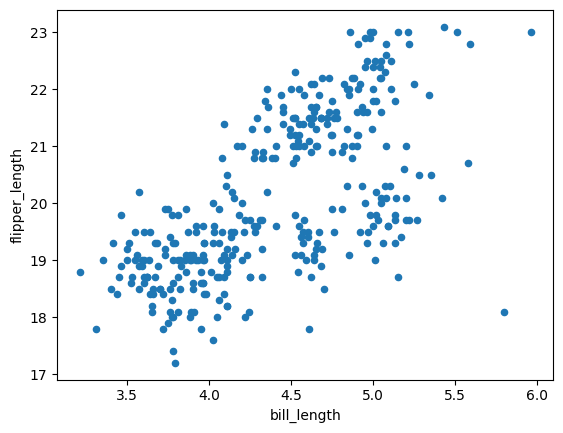

In [39]:
penguins.plot.scatter("bill_length", "flipper_length")

Based on the initial scatterplot of bill length vs flipper length, I like the general linear relationship trending upwards. This trend should make it easier for me to create my plots.

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

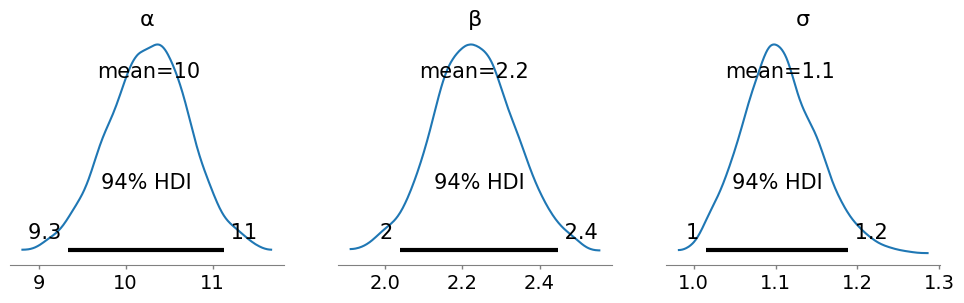

In [87]:
az.plot_posterior(idata_penguins, var_names=["~μ"], figsize=(12, 3))

In [51]:
species_idx = penguins.species.cat.codes.values

species_codes = penguins.species.cat.categories

pg_coords = {"species":species_codes}

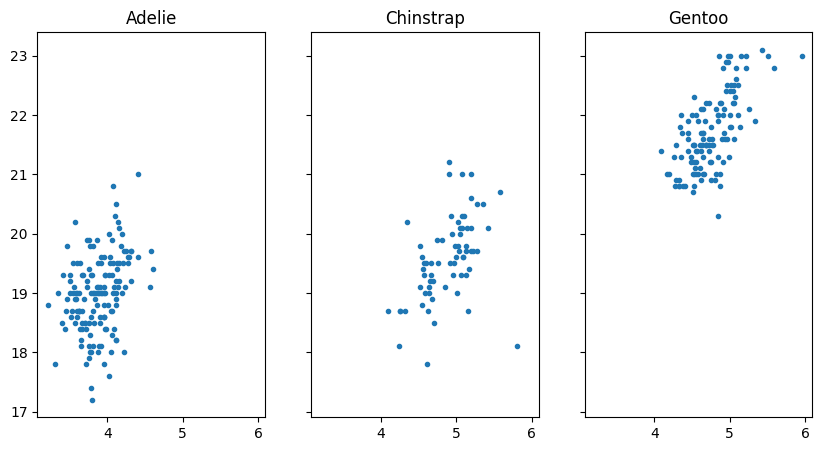

In [52]:
# Set up 3 plots for 3 species
_, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

# Make a scatter plot for each position
for i, p in enumerate(species_codes):
    ax[i].scatter(
        x = penguins.query('species == @p')['bill_length'],
        y =  penguins.query('species == @p')['flipper_length'],
        marker=".")
    ax[i].set_title(f"{p}")

In [ ]:
with pm.Model() as model_penguins:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model, using 'bill_length' as the independent variable
    μ = pm.Deterministic("μ", α + β * penguins['bill_length'])

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 1)

    #likelihood
    # Using Normal distribution for continuous 'flipper_length' data
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=penguins['flipper_length'])

    idata_penguins = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_salary, model=model_salary, extend_inferencedata=True)

In [ ]:
with pm.Model(coords={"species": species_codes}) as nh_model:
    # Priors
    α = pm.Normal("α", mu=0, sigma=3, dims="species")  # Intercept for each species
    β = pm.Normal("β", mu=0, sigma=10, dims="species") # Slope for each species
    σ = pm.HalfNormal("σ", 1)                          # Noise standard deviation

    # Linear
    mu = α[species_idx] + β[species_idx] * penguins['bill_length']

    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=σ, observed=penguins['flipper_length'])

    # Sampling
    idata_nh = pm.sample(init="jitter+adapt_diag", tune=2000, return_inferencedata=True)

/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


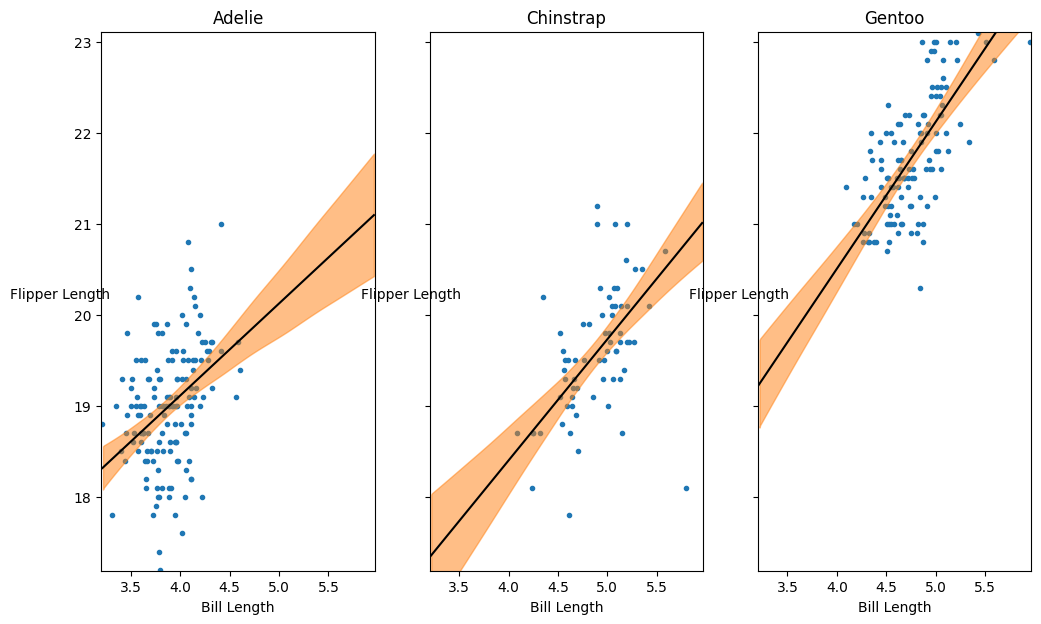

In [68]:

# Set up 3 plots for 3 species
_, ax = plt.subplots(1, 3, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)

# Set up x values
x_range = np.linspace(penguins['bill_length'].min(), penguins['bill_length'].max(), 10)

# Grab posterior info
posterior = az.extract(idata_nh)

# For each position
for i, p in enumerate(species_codes):
    # Plot the raw data
    ax[i].scatter(
        x = penguins.query('species == @p')['bill_length'],
        y = penguins.query('species == @p')['flipper_length'],
        marker=".")

    # Gives our graphs titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("Bill Length")
    ax[i].set_ylabel("Flipper Length", labelpad=10, rotation=0)

    # Grab the slope and y-int
    alphas = posterior["α"].sel(species=p)
    betas = posterior["β"].sel(species=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    # Plot the line of best fit
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    # Plot a 94% HDI of the line of best fit
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    # Set the limits of our graph windows
    plt.xlim(penguins['bill_length'].min() - 0.01, penguins['bill_length'].max() + 0.01)
    plt.ylim(penguins['flipper_length'].min() - 0.01, penguins['flipper_length'].max() + 0.01)

The trend of the scattered data and the orange 94% HDI region is pretty good. There is a clear increasing linear trend between bill length and flipper length. The scatterplot for the Adelie penguin shows more variation and less steep of a slope compared to the chinstrap and gentoo plots. Overall, I'm satisfied with my results and this matches what I expected.

In [ ]:
pm.sample_posterior_predictive(idata_nh, model=nh_model,  extend_inferencedata=True)

<Axes: xlabel='y'>

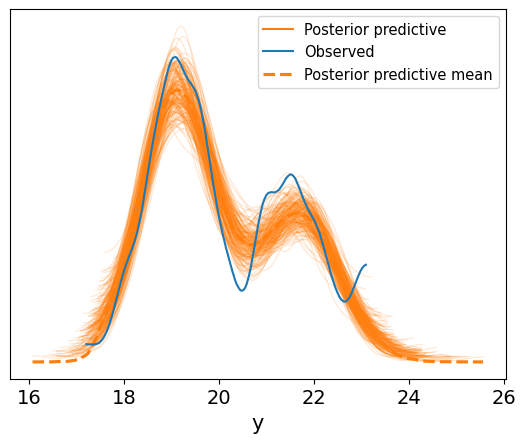

In [58]:
az.plot_ppc(idata_nh, num_pp_samples=200, colors=["C1", "C0", "C1"])

My posterior predictive check does an excellent job of aligning with the observed data. From the starting point on the left side of the plot, it follows the steep rise, hits the peak, and falls back down quickly which matches my observed. My check misses a break of structure on the relative maxima. But overall, I'm satisfied with my predictive check.

Text(0, 0.5, 'Flipper Length')

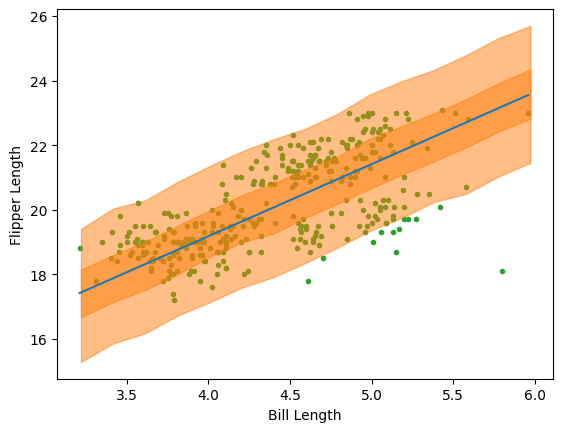

In [85]:


mean_line = idata_penguins.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
masses = np.random.normal(penguins["bill_length"].values, 0.01)
idx = np.argsort(masses)
x = np.linspace(masses.min(), masses.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_penguins.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(masses[idx], y_pred_q[i].values[idx])(x)
        for i in range(4) ])
#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(penguins["bill_length"], penguins["flipper_length"], "C2.", zorder=-3)
ax.plot(penguins["bill_length"].values[idx], mean_line.values[idx], c="C0")

for whole, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, whole, ub, color="C1", alpha=0.5)
ax.set_xlabel("Bill Length")
ax.set_ylabel("Flipper Length")

<Axes: xlabel='y_pred'>

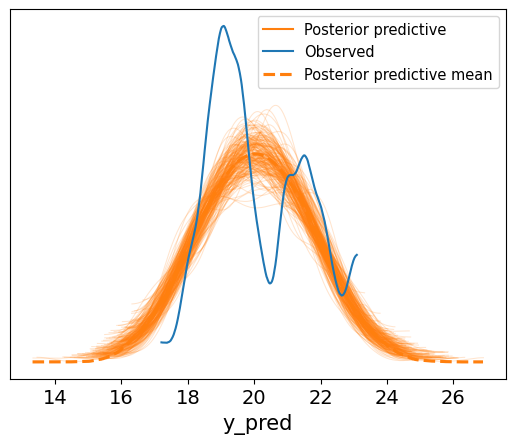

In [86]:
az.plot_ppc(idata_penguins, num_pp_samples=200, colors=["C1", "C0", "C1"])

It does a decent job of matching the data in the data set. It follows the general trend of starting from the bottom, rising towards the middle, and falling back down. However, it did not match the various relative peaks in the data which is hard to model accurately. It also missed a major dip near the mean that I was unable to model.